In [48]:
import pandas as pd
import numpy as np

In [49]:
df = pd.read_csv('../data/raw/application_train.csv')

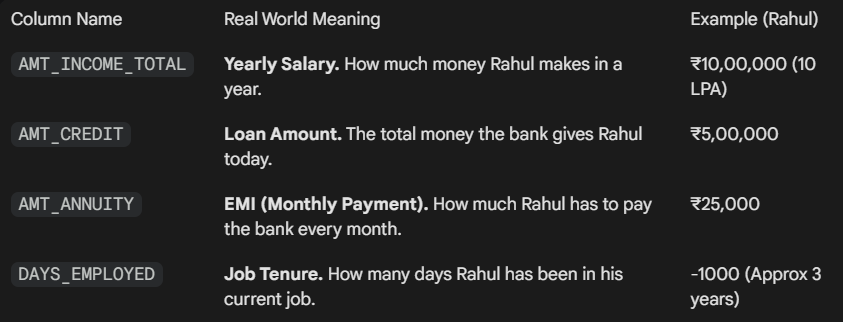

In [50]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
df.isnull().sum()

SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 122, dtype: int64

In [52]:
df.isnull().sum().sum()

np.int64(9152465)

In [53]:
df.duplicated().sum()

np.int64(0)

1. FIX ANOMALIES

In [54]:
# 'DAYS_EMPLOYED' has a value 365243 which is essentially "Null" or "Retired"
# We replace it with NaN so our math doesn't break
# The value 365243 means "Unemployed" or "Pensioner". We replace it with NaN.
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].replace(365243, np.nan)

In [55]:
# Create AGE_YEARS (Convert negative days to positive years)
df['AGE_YEARS'] = df['DAYS_BIRTH'] / -365

2. FEATURE ENGINEERING (Financial Ratios)

Ratio A: Credit-to-Income Ratio (AMT_CREDIT / AMT_INCOME_TOTAL)
    The Math: ₹5,00,000 Loan / ₹10,00,000 Salary = 0.5

    The Business Meaning: "How heavy is this loan compared to his life?"

    Why it predicts risk:

    If the ratio is 0.5, Rahul is borrowing half his yearly salary. That is safe.

    If the ratio is 5.0, Rahul is borrowing 5 times his salary. He will likely default. High Ratio = High Risk.

Ratio B: Annuity-to-Income Ratio (AMT_ANNUITY / AMT_INCOME_TOTAL)
    The Math: ₹25,000 EMI / (₹10,00,000 / 12 months) ≈ 30% of monthly salary.

    The Business Meaning: "Debt Burden Ratio" (DBR).

    Why it predicts risk:

    Banks usually have a rule: If EMI is more than 40% of your monthly salary, reject.

    If this number is high, Rahul is "house poor" (has no cash left for food/rent). He will default on the loan to buy food.

Ratio C: Credit Term (AMT_CREDIT / AMT_ANNUITY)
    The Math: 500000 / 25000 = 20 months.

    The Business Meaning: How long until Rahul is free?

    Why it predicts risk: Longer loans (e.g., 60 months) are riskier because a lot can go wrong in 5 years (job loss, medical emergency).

In [56]:
# A. Credit to Income Ratio: How big is the loan compared to their salary?
df['CREDIT_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']

# B. Annuity to Income Ratio: How much of their monthly salary goes to paying this loan?
df['ANNUITY_INCOME_RATIO'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']

# C. Credit Term: How long is the loan? (Credit / Annuity)
df['CREDIT_TERM'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']

In [57]:
print("Financial Features Created.")
print("-" * 30)
print("First row ratios:")
print(df[['CREDIT_INCOME_RATIO', 'ANNUITY_INCOME_RATIO', 'CREDIT_TERM']].iloc[0])

Financial Features Created.
------------------------------
First row ratios:
CREDIT_INCOME_RATIO      2.007889
ANNUITY_INCOME_RATIO     0.121978
CREDIT_TERM             16.461104
Name: 0, dtype: float64


In [58]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AGE_YEARS,CREDIT_INCOME_RATIO,ANNUITY_INCOME_RATIO,CREDIT_TERM
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,1.0,25.920548,2.007889,0.121978,16.461104
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,45.931507,4.790750,0.132217,36.234085
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,52.180822,2.000000,0.100000,20.000000
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,52.068493,2.316167,0.219900,10.532818
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,54.608219,4.222222,0.179963,23.461618


3. Encoding

In [59]:
# This converts all text columns (like 'Gender') into numbers (0 and 1)
print(f"Shape before encoding: {df.shape}")

df = pd.get_dummies(df)

print(f"Shape after encoding: {df.shape}")

Shape before encoding: (307511, 126)
Shape after encoding: (307511, 250)


FILL MISSING VALUES (IMPUTATION)

In [60]:
df.isnull().sum()

SK_ID_CURR                         0
TARGET                             0
CNT_CHILDREN                       0
AMT_INCOME_TOTAL                   0
AMT_CREDIT                         0
                                  ..
WALLSMATERIAL_MODE_Panel           0
WALLSMATERIAL_MODE_Stone, brick    0
WALLSMATERIAL_MODE_Wooden          0
EMERGENCYSTATE_MODE_No             0
EMERGENCYSTATE_MODE_Yes            0
Length: 250, dtype: int64

In [61]:
df.isnull().sum().sum()

np.int64(8443492)

In [62]:
# We use the median because it's robust to outliers
from sklearn.impute import SimpleImputer
# Get all column names
cols = df.columns
# Create the "Repair Tool"
imputer = SimpleImputer(strategy='median')
# Apply the repair (This converts dataframe to a numpy array)
df_imputed_array = imputer.fit_transform(df)
# Convert back to DataFrame so we don't lose column names
df_final = pd.DataFrame(df_imputed_array, columns=cols)
print("Missing values filled.")
print(f"Any NaNs left? {df_final.isnull().sum().sum()}")

Missing values filled.
Any NaNs left? 0


In [63]:
df_final.isnull().sum()

SK_ID_CURR                         0
TARGET                             0
CNT_CHILDREN                       0
AMT_INCOME_TOTAL                   0
AMT_CREDIT                         0
                                  ..
WALLSMATERIAL_MODE_Panel           0
WALLSMATERIAL_MODE_Stone, brick    0
WALLSMATERIAL_MODE_Wooden          0
EMERGENCYSTATE_MODE_No             0
EMERGENCYSTATE_MODE_Yes            0
Length: 250, dtype: int64

In [64]:
df_final.isnull().sum().sum()

np.int64(0)

SAVE PROCESSED DATA

In [65]:
# We save to the 'processed' folder
df_final.to_csv('../data/processed/train_processed.csv', index=False)

print("Success! Processed data saved to 'data/processed/train_processed.csv'")

Success! Processed data saved to 'data/processed/train_processed.csv'
